# Regularization of CNN

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping.pytorchtools import EarlyStopping

%matplotlib inline
torch.manual_seed(17)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

Files already downloaded and verified


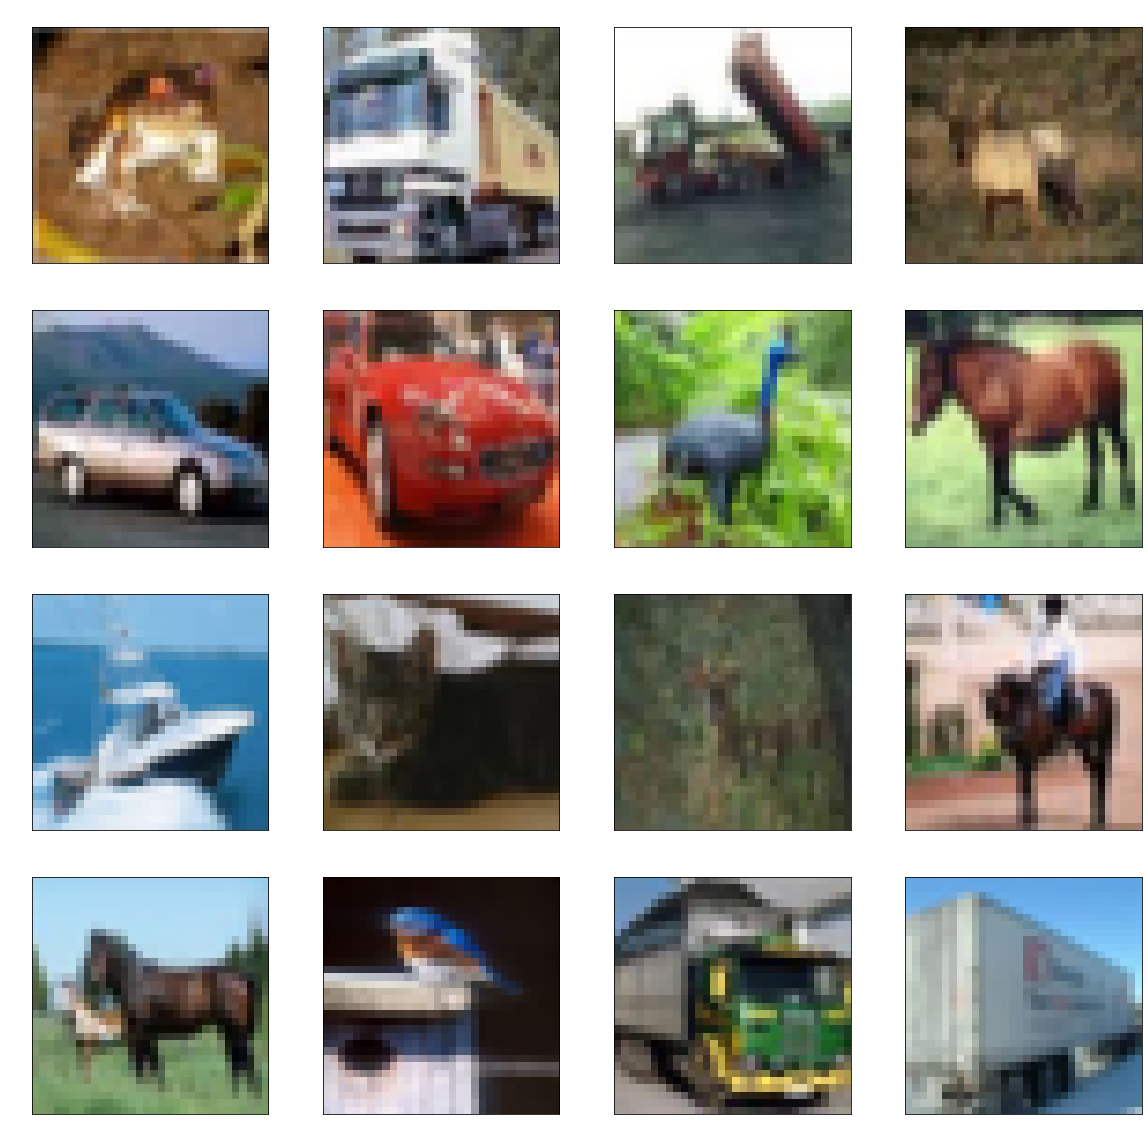

In [51]:
min_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    ])
dataset = torchvision.datasets.CIFAR10("/media/miro/4tb_cached/",
                                       transform=min_transform,
                                       download=True)

fig, axs = plt.subplots(4, 4,figsize=(20,20))
sample = np.random.randint(0,len(dataset),64)
for i in range(16):
    img, target = dataset.__getitem__(i)
    img = img.permute(1,2,0)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title("{} min: {:.2f} max: {:.2f}".format(dataset.classes[target],torch.min(img),torch.max(img)))

In [52]:
batch_size =  64
split = (0.4, 0.3, 0.3)
training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [53]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)


        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.0, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #batch_size x 64 x 15 x 15
        x = self.dropout1(x)
        #batch_size x 64 x 15 x 15
        x = self.pool(F.relu(self.conv2(x)))
        #batch_size x 64 x 6 x 6
        x = self.dropout1(x)
        #batch_size x 64 x 6 x 6
        x = self.pool(F.relu(self.conv3(x)))
        #batch_size x 128 x 2 x 2
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        #batch_size x 1 x 512

        x = F.relu(self.fc1(x))
        #batch_size x 1 x 128

        x = F.relu(self.fc2(x))
        #batch_size x 1 x 64

        x = F.relu(self.fc3(x))
        #batch_size x 1 x 32

        x = self.fc4(x)
        #batch_size x 1 x 10

        return x


In [54]:
def visualize_batch_loss(batch_train_losses):
    plt.figure(figsize=(15,3))
    xx = np.arange(0,len(batch_train_losses),1)
    y_train =  np.array(batch_train_losses)
    plt.plot(xx, y_train)
    plt.legend(["Training Loss"],labelcolor='black')
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.title("Loss of validation and training set")
    plt.show()

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()

In [56]:
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0):
    avg_train_losses = []
    avg_valid_losses = []
    avg_valid_acc = []
    batch_train_losses= []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes in train_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        for input_data, classes in valid_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)

            valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])



        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stop_count:
        model.load_state_dict(torch.load("net.pth"))

    return avg_valid_losses, avg_train_losses, model, batch_train_losses

In [57]:
def print_accuracy(model, criterion, test_loader):
    y_gts = np.array([])
    y_preds = np.array([])
    for input_data, classes in test_loader:
        x = input_data.to(device)
        y = classes.long().to(device)
        output = model(x)
        _, pred = torch.max(output, 1)

        y_gts = np.hstack((y_gts, y.cpu().numpy()))
        y_preds = np.hstack((y_preds, pred.cpu().numpy()))

    print("Accuracy the NN is : {:2.2f} %".format(np.sum(y_gts==y_preds)/y_preds.shape[0]*100))

## Experiments
### 1. Optimizer choice, Learning Rate tuning.
* Lets set learning rate with Stochastic gradient descent to 0.5
* This results in oscillation around local minimum
* https://cs231n.github.io/neural-networks-3/

[ 1/20] train_loss: 2.28878 valid_loss: 2.15317 valid_acc: 17.19 %
[ 2/20] train_loss: 2.30182 valid_loss: 2.30579 valid_acc: 10.21 %
[ 3/20] train_loss: 2.25362 valid_loss: 2.31544 valid_acc: 12.92 %
[ 4/20] train_loss: 2.08881 valid_loss: 1.91033 valid_acc: 27.10 %
[ 5/20] train_loss: 1.98592 valid_loss: 1.91169 valid_acc: 26.38 %
[ 6/20] train_loss: 1.86003 valid_loss: 1.85273 valid_acc: 30.61 %
[ 7/20] train_loss: 1.77387 valid_loss: 1.62769 valid_acc: 39.78 %
[ 8/20] train_loss: 1.63907 valid_loss: 2.21954 valid_acc: 32.72 %
[ 9/20] train_loss: 1.56585 valid_loss: 1.62524 valid_acc: 41.29 %
[10/20] train_loss: 1.48237 valid_loss: 1.51794 valid_acc: 46.31 %
[11/20] train_loss: 1.43138 valid_loss: 1.46476 valid_acc: 47.80 %
[12/20] train_loss: 1.38469 valid_loss: 1.87509 valid_acc: 32.52 %
[13/20] train_loss: 1.34182 valid_loss: 1.64346 valid_acc: 43.78 %
[14/20] train_loss: 1.28576 valid_loss: 1.41794 valid_acc: 50.46 %
[15/20] train_loss: 1.22791 valid_loss: 1.42689 valid_acc: 51.

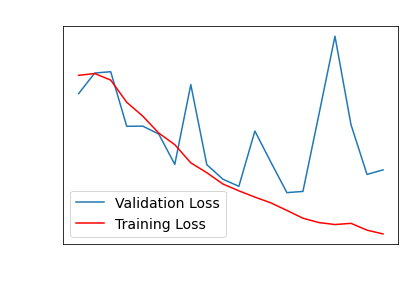

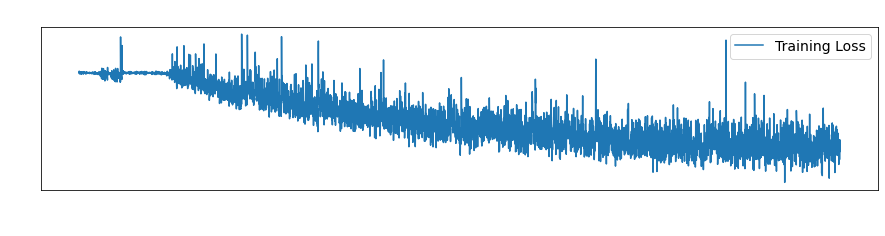

In [38]:
model = Net().to(device)
criterion_CE = nn.CrossEntropyLoss()

optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.5)
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

#### 1. Low learning rate
* decrease the learning
* results in very slow learning
* we can either add learning rate scheduler that will decrease the learning the rate  or use different optimizer
* results in vanishing gradient issue

[ 1/20] train_loss: 2.31044 valid_loss: 2.31151 valid_acc: 9.61 %
[ 2/20] train_loss: 2.30998 valid_loss: 2.31088 valid_acc: 9.61 %
[ 3/20] train_loss: 2.30935 valid_loss: 2.31029 valid_acc: 9.61 %
[ 4/20] train_loss: 2.30880 valid_loss: 2.30976 valid_acc: 9.61 %
[ 5/20] train_loss: 2.30836 valid_loss: 2.30926 valid_acc: 9.61 %
[ 6/20] train_loss: 2.30790 valid_loss: 2.30881 valid_acc: 9.61 %
[ 7/20] train_loss: 2.30751 valid_loss: 2.30838 valid_acc: 9.61 %
[ 8/20] train_loss: 2.30715 valid_loss: 2.30799 valid_acc: 9.61 %
[ 9/20] train_loss: 2.30677 valid_loss: 2.30763 valid_acc: 9.61 %
[10/20] train_loss: 2.30646 valid_loss: 2.30730 valid_acc: 9.61 %
[11/20] train_loss: 2.30620 valid_loss: 2.30699 valid_acc: 9.61 %
[12/20] train_loss: 2.30591 valid_loss: 2.30671 valid_acc: 9.61 %
[13/20] train_loss: 2.30567 valid_loss: 2.30644 valid_acc: 9.61 %
[14/20] train_loss: 2.30543 valid_loss: 2.30620 valid_acc: 9.61 %
[15/20] train_loss: 2.30523 valid_loss: 2.30597 valid_acc: 9.61 %
[16/20] tr

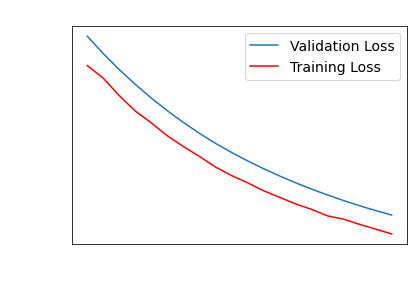

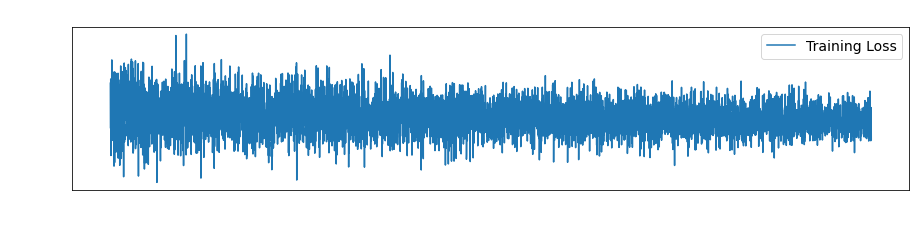

In [35]:
model = Net().to(device)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

[ 1/20] train_loss: 2.30324 valid_loss: 2.30266 valid_acc: 10.21 % lr: 0.10000
[ 2/20] train_loss: 2.30296 valid_loss: 2.30254 valid_acc: 10.06 % lr: 0.10000
[ 3/20] train_loss: 2.30253 valid_loss: 2.30239 valid_acc: 10.22 % lr: 0.10000
[ 4/20] train_loss: 2.30123 valid_loss: 2.29802 valid_acc: 10.59 % lr: 0.10000
[ 5/20] train_loss: 2.23511 valid_loss: 2.11046 valid_acc: 19.25 % lr: 0.07500
[ 6/20] train_loss: 2.09033 valid_loss: 2.12567 valid_acc: 18.42 % lr: 0.07500
[ 7/20] train_loss: 2.00856 valid_loss: 2.06819 valid_acc: 21.72 % lr: 0.07500
[ 8/20] train_loss: 1.86548 valid_loss: 1.77051 valid_acc: 33.57 % lr: 0.07500
[ 9/20] train_loss: 1.74141 valid_loss: 1.67509 valid_acc: 37.82 % lr: 0.07500
[10/20] train_loss: 1.63218 valid_loss: 1.53893 valid_acc: 43.32 % lr: 0.05625
[11/20] train_loss: 1.50682 valid_loss: 1.56082 valid_acc: 42.97 % lr: 0.05625
[12/20] train_loss: 1.42699 valid_loss: 1.37868 valid_acc: 49.49 % lr: 0.05625
[13/20] train_loss: 1.35927 valid_loss: 1.55129 vali

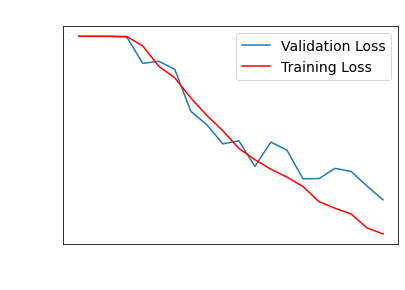

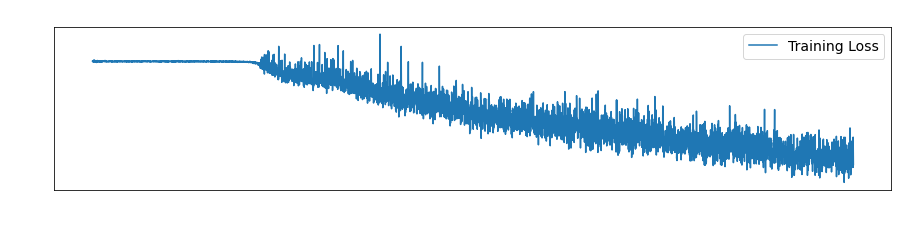

In [37]:
model = Net().to(device)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_SGD,[5,10,15, 18],0.75)
avg_valid_losses, avg_train_losses, model, batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD,
                                                                      scheduler=scheduler)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

## Great content on the topic
* https://ruder.io/optimizing-gradient-descent/
* Adam is generally good, due to adaptive learning rate for each parameter update
* is another method that computes adaptive learning rates for each parameter.
In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients , similar to momentum.

[ 1/20] train_loss: 1.98961 valid_loss: 1.76387 valid_acc: 34.09 %
[ 2/20] train_loss: 1.67480 valid_loss: 1.57847 valid_acc: 40.29 %
[ 3/20] train_loss: 1.49268 valid_loss: 1.50549 valid_acc: 43.61 %
[ 4/20] train_loss: 1.37970 valid_loss: 1.34952 valid_acc: 50.54 %
[ 5/20] train_loss: 1.28030 valid_loss: 1.30299 valid_acc: 51.97 %
[ 6/20] train_loss: 1.21258 valid_loss: 1.31307 valid_acc: 52.59 %
[ 7/20] train_loss: 1.15260 valid_loss: 1.21893 valid_acc: 56.32 %
[ 8/20] train_loss: 1.07414 valid_loss: 1.16391 valid_acc: 57.73 %
[ 9/20] train_loss: 1.02565 valid_loss: 1.25917 valid_acc: 56.46 %
[10/20] train_loss: 0.97545 valid_loss: 1.12176 valid_acc: 59.57 %
[11/20] train_loss: 0.93581 valid_loss: 1.11903 valid_acc: 60.21 %
[12/20] train_loss: 0.88773 valid_loss: 1.11211 valid_acc: 61.03 %
[13/20] train_loss: 0.84915 valid_loss: 1.14272 valid_acc: 60.37 %
[14/20] train_loss: 0.80718 valid_loss: 1.12836 valid_acc: 61.76 %
[15/20] train_loss: 0.77705 valid_loss: 1.15643 valid_acc: 60.

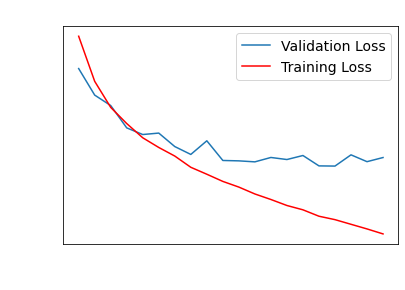

In [59]:
model = Net().to(device)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,20,train_loader,valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)


### 2.Dropout
* simple, but works like a charm

[ 1/20] train_loss: 1.97809 valid_loss: 1.78175 valid_acc: 33.32 %
[ 2/20] train_loss: 1.68887 valid_loss: 1.57432 valid_acc: 40.68 %
[ 3/20] train_loss: 1.54028 valid_loss: 1.42528 valid_acc: 47.27 %
[ 4/20] train_loss: 1.43615 valid_loss: 1.37711 valid_acc: 49.16 %
[ 5/20] train_loss: 1.36811 valid_loss: 1.31752 valid_acc: 53.26 %
[ 6/20] train_loss: 1.30369 valid_loss: 1.24519 valid_acc: 54.68 %
[ 7/20] train_loss: 1.25975 valid_loss: 1.23594 valid_acc: 56.10 %
[ 8/20] train_loss: 1.20642 valid_loss: 1.14640 valid_acc: 58.77 %
[ 9/20] train_loss: 1.16469 valid_loss: 1.15715 valid_acc: 58.59 %
[10/20] train_loss: 1.12447 valid_loss: 1.09735 valid_acc: 60.84 %
[11/20] train_loss: 1.08880 valid_loss: 1.05577 valid_acc: 62.25 %
[12/20] train_loss: 1.06170 valid_loss: 1.06859 valid_acc: 62.86 %
[13/20] train_loss: 1.04014 valid_loss: 1.03891 valid_acc: 63.34 %
[14/20] train_loss: 1.00454 valid_loss: 1.01697 valid_acc: 64.39 %
[15/20] train_loss: 0.97338 valid_loss: 0.97491 valid_acc: 65.

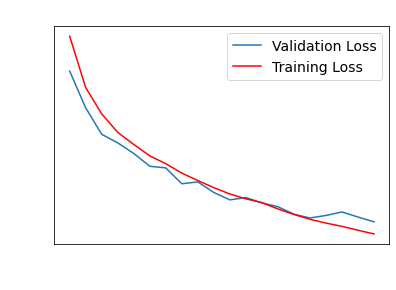

In [39]:
model = Net().to(device)
model.dropout1 = nn.Dropout(0.2)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  20,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

In [47]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.batch_norm_conv1 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.batch_norm_conv2 = nn.BatchNorm2d(64, affine=False)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batch_norm_conv3 = nn.BatchNorm2d(128, affine=False)


        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.batch_norm1 = nn.BatchNorm1d(128, affine=False)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64, affine=False)

        self.fc3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32, affine=False)

        self.fc4 = nn.Linear(32, 10)


        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.0, inplace=False)

    def forward(self, x):
        x = self.pool(self.batch_norm_conv1(F.relu(self.conv1(x))))
        #batch_size x 64 x 15 x 15
        x = self.dropout1(x)
        #batch_size x 64 x 15 x 15
        x = self.pool(self.batch_norm_conv2(F.relu(self.conv2(x))))
        #batch_size x 64 x 6 x 6
        x = self.dropout1(x)
        #batch_size x 64 x 6 x 6
        x = self.pool(self.batch_norm_conv3(F.relu(self.conv3(x))))
        #batch_size x 128 x 2 x 2
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        #batch_size x 1 x 512

        x = self.batch_norm1(F.relu(self.fc1(x)))
        #batch_size x 1 x 128

        x = self.batch_norm2(F.relu(self.fc2(x)))
        #batch_size x 1 x 64

        x = self.batch_norm3(F.relu(self.fc3(x)))
        #batch_size x 1 x 32

        x = self.fc4(x)
        #batch_size x 1 x 10

        return x


### 3. Batch normalization
* goal to normalize output based on the statistics of the batch
* original paper recommends  to use batch norm before activation -https://arxiv.org/pdf/1502.03167.pdf
* however the last body of research uses it after activation

[1/5] train_loss: 1.56239 valid_loss: 1.31641 valid_acc: 53.79 %
[2/5] train_loss: 1.20166 valid_loss: 1.17505 valid_acc: 59.21 %
[3/5] train_loss: 1.00169 valid_loss: 1.11781 valid_acc: 61.29 %
[4/5] train_loss: 0.85146 valid_loss: 1.07484 valid_acc: 64.27 %
[5/5] train_loss: 0.73810 valid_loss: 1.12711 valid_acc: 61.79 %
Accuracy the NN is : 62.32 %


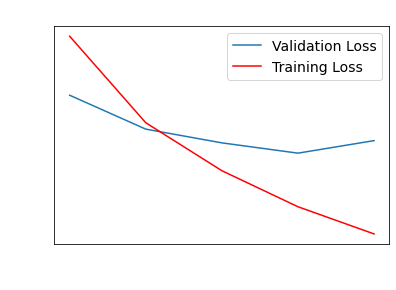

In [48]:
model = NetBatchNorm().to(device)
model.dropout1 = nn.Dropout(0.0)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  5,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)



### 4. Dataset Augmentation
* https://pytorch.org/vision/stable/transforms.html
1. start conservative, first add noise, flip
2. random erasing
3. affine transform

[ 1/20] train_loss: 2.05749 valid_loss: 1.89053 valid_acc: 25.67 %
[ 2/20] train_loss: 1.81372 valid_loss: 1.74298 valid_acc: 31.65 %
[ 3/20] train_loss: 1.70739 valid_loss: 1.67428 valid_acc: 35.82 %
[ 4/20] train_loss: 1.60014 valid_loss: 1.57940 valid_acc: 40.05 %
[ 5/20] train_loss: 1.54296 valid_loss: 1.52012 valid_acc: 41.78 %
[ 6/20] train_loss: 1.49156 valid_loss: 1.47915 valid_acc: 44.78 %
[ 7/20] train_loss: 1.42433 valid_loss: 1.49716 valid_acc: 43.81 %
[ 8/20] train_loss: 1.39445 valid_loss: 1.40329 valid_acc: 47.71 %
[ 9/20] train_loss: 1.34517 valid_loss: 1.34902 valid_acc: 51.07 %
[10/20] train_loss: 1.30746 valid_loss: 1.35103 valid_acc: 50.00 %
[11/20] train_loss: 1.29234 valid_loss: 1.29521 valid_acc: 52.12 %
[12/20] train_loss: 1.24475 valid_loss: 1.31597 valid_acc: 51.57 %
[13/20] train_loss: 1.22649 valid_loss: 1.29057 valid_acc: 51.91 %
[14/20] train_loss: 1.19504 valid_loss: 1.22427 valid_acc: 54.91 %
[15/20] train_loss: 1.16960 valid_loss: 1.29308 valid_acc: 52.

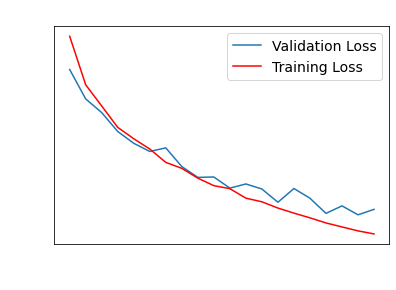

In [45]:
aug_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.RandomVerticalFlip(),
                                    torchvision.transforms.RandomHorizontalFlip(),
                                    ])
dataset.transform = aug_transform

model = Net().to(device)
model.dropout1 = nn.Dropout(0.0)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  20,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None,
                                                  early_stop_count=0)
dataset.transform = min_transform
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

### 5. Early stopping

[  1/100] train_loss: 1.68481 valid_loss: 1.48899 valid_acc: 48.61 %
Validation loss decreased (inf --> 1.488990).  Saving model ...
[  2/100] train_loss: 1.29892 valid_loss: 1.19762 valid_acc: 57.83 %
Validation loss decreased (1.488990 --> 1.197625).  Saving model ...
[  3/100] train_loss: 1.15846 valid_loss: 1.09460 valid_acc: 60.64 %
Validation loss decreased (1.197625 --> 1.094600).  Saving model ...
[  4/100] train_loss: 1.08768 valid_loss: 1.09054 valid_acc: 61.12 %
Validation loss decreased (1.094600 --> 1.090537).  Saving model ...
[  5/100] train_loss: 1.01520 valid_loss: 1.13644 valid_acc: 60.26 %
EarlyStopping counter: 1 out of 10
[  6/100] train_loss: 0.95502 valid_loss: 1.07442 valid_acc: 62.30 %
Validation loss decreased (1.090537 --> 1.074416).  Saving model ...
[  7/100] train_loss: 0.92009 valid_loss: 0.92299 valid_acc: 67.64 %
Validation loss decreased (1.074416 --> 0.922993).  Saving model ...
[  8/100] train_loss: 0.88935 valid_loss: 1.10317 valid_acc: 62.43 %
Earl

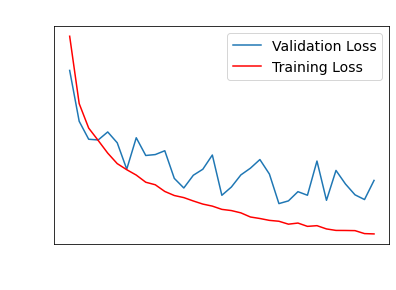

In [49]:
model = NetBatchNorm().to(device)
model.dropout1 = nn.Dropout(0.2)
optimizer_SGD = torch.optim.AdamW(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  100,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None,
                                                  early_stop_count=10)
visualize_loss(avg_valid_losses,avg_train_losses)
dataset.transform = min_transform
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

# Pokuste sa vytvorit model, a natrenujte model  na CIFAR  s dropoutom a batch normalizaciou na jednotlivych vrstvach.